## 라이브러리 임포트 

In [55]:
import glob 
import matplotlib.pyplot as plt 
import cv2 
import os ,time
import numpy as np 
import random 
import mediapipe as mp
import numpy as np
import glob 

from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten , BatchNormalization
from tensorflow.keras.models import load_model
from collections import deque

### 함수 정의

* 'https://www.adobe.com/kr/express/feature/image/remove-background' 이 사이트에서 flag를 제외한 이미지들을 모두 png파일로 바꾸기


In [60]:
def resize_img(name,img_size=100):
    '''  
    name could be animal or flag
    this def resize the img 
    '''
    if not os.path.exists(f'./resize_{name}'):
        os.mkdir(f'./resize_{name}')

        path = glob.glob(f'./{name}/*')
        for i in range(4):
            img = cv2.imread(path[i])
            resized_img = cv2.resize(img,(img_size,img_size))
            cv2.imwrite(f'./resize_{name}/{i}.png',resized_img)
    else:
        print('이미지가 이미 만들어져 있습니다.')

def bring_img(name):

    file_path = glob.glob(f'./photo_{name}/*')

    img0 = cv2.imread(file_path[0])
    img1 = cv2.imread(file_path[1])
    img2 = cv2.imread(file_path[2])
    alpha0 = img0[:,:,:] / 255
    alpha1 = img1[:,:,:] / 255
    alpha2 = img2[:,:,:] / 255

    return (img0, img1, img2, alpha0, alpha1, alpha2,)

def put_4img(frame,img0,img1, img2, alpha0, alpha1,alpha2,img_size = 100 ,right_x=0, right_y=190, top_x=270 ,top_y =0 , left_x=540, left_y= 190, ):
    frame[left_y:left_y+img_size, left_x:left_x+img_size] = frame[left_y:left_y+img_size, left_x:left_x+img_size] * (1-alpha1)+ img1[:,:,:3] * alpha1
    frame[top_y:top_y+img_size, top_x:top_x+img_size] = frame[top_y:top_y+img_size, top_x:top_x+img_size] * (1-alpha2)+ img2[:,:,:3] * alpha2
    frame[right_y:right_y+img_size, right_x:right_x+img_size] = frame[right_y:right_y+img_size, right_x:right_x+img_size] * (1-alpha0)+ img0[:,:,:3] * alpha0

    return frame 


img_size = 100
colors = [(245,117,16), (117,245,16) , (16,117,245),]
right_x,right_y = 0,190
top_x,top_y = 270,0
left_x,left_y = 540,190
bottom_x,bottom_y = 270,380


# 학습시킬 데이터 지정
actions = ['left','top','right']
seq_length = 30 # window의 사이즈
secs_for_action = 30 # 하나의 제스쳐를 찍는데 걸리는 시간


### 이미지 크기 바꾸기

In [68]:
resize_img('animal')
resize_img('flag')
resize_img('fruit')
resize_img('balls')

이미지가 이미 만들어져 있습니다.
이미지가 이미 만들어져 있습니다.
이미지가 이미 만들어져 있습니다.
이미지가 이미 만들어져 있습니다.


### 포토샵을 활용해서 배경을 바꾼 파일들을 photo_name 에서 불러오기

In [116]:
animal_path = glob.glob('./photo_animal/*')
flag_path = glob.glob('./photo_flag/*')

### 이미지 확인해 보기

In [ ]:
# 동물 이미지 확인해보기 
cap = cv2.VideoCapture(0)

animal = bring_img('animal')
flag = bring_img('flag')

while cap.isOpened():
    ret, frame = cap.read()

    put_4img(frame,animal[0],animal[1],animal[2],animal[3], animal[4],animal[5],animal[6],animal[7] )
    cv2.imshow(f'animal', cv2.flip(frame, 1))

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [174]:
animal= bring_img('animal')
flag = bring_img('flag')
len(flag)

6

In [36]:
# 국기 이미지 확인해보기 
cap = cv2.VideoCapture(0)

animal= bring_img('animal')
flag = bring_img('flag')

while cap.isOpened():
    ret, frame = cap.read()

    put_4img(frame,flag[0],flag[1],flag[2],flag[3],flag[4],flag[5], )
    cv2.imshow(f'flag', cv2.flip(frame, 1))

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### 데이터 생성

In [15]:
# 초기화
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    max_num_hands = 1, # 몇 개의 손을 인식할 것인지
    min_detection_confidence = 0.5,
    min_tracking_confidence = 0.5)

# 웹캠 열기
cap = cv2.VideoCapture(0)

created_time = int(time.time())
os.makedirs('dataset', exist_ok=True) # 데이터 셋을 저장할 폴더 만들기

# 웹캠을 열어서 데이터 모으기
while cap.isOpened():
    for idx, action in enumerate(actions):
        data = []

        # 이미지 읽기
        ret, img = cap.read()

        # flip, 웹캠 이미지가 거울처럼 나타나기 때문
        img = cv2.flip(img, 1)

        # 어떤 제스쳐를 학습시킬 것인지 표시
        cv2.putText(img, f'Waiting for collecting {action.upper()} action...', org=(10,30),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255,255,255), thickness=2)
        
        #3초동안 대기
        cv2.imshow('img', img)
        cv2.waitKey(3000)

        start_time = time.time()
        
        #30초동안 촬영
        while time.time() - start_time < secs_for_action:
            ret, img = cap.read()

            img = cv2.flip(img, 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # opencv는 기본적으로 BGR로 영상을 읽기 때문에 RGB로 바꿔야 함
            result = hands.process(img) # RGB로 바꾼 데이터를 result에 저장
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            if result.multi_hand_landmarks is not None:
                for res in result.multi_hand_landmarks:
                    joint = np.zeros((21,4))
                    for j,lm in enumerate(res.landmark):
                        joint[j] = [lm.x, lm.y, lm.z, lm.visibility] # 각 점의 x, y, z 좌표 & 점이 이미지 상에서 보이는지 안 보이는지

                    # 점들 간의 각도 계산하기
                    v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3] # Parent joint
                    v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3] # Child joint
                    v = v2 - v1 # v2와 v1 사이의 벡터 구하기

                    # 벡터 정규화 시키기(단위 벡터 구하기)
                    v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

                    # 점곱을 구한 다음 arccos으로 각도 구하기
                    angle = np.arccos(np.einsum('nt,nt->n',
                        v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                        v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

                    angle = np.degrees(angle) # 라디안을 각도로 바꾸기

                    angle_label = np.array([angle], dtype=np.float32)
                    angle_label = np.append(angle_label, idx) # 라벨 추가

                    d = np.concatenate([joint.flatten(), angle_label])

                    data.append(d)

                    mp_drawing.draw_landmarks(img, res, mp_hands.HAND_CONNECTIONS) # 랜드마크 그리기
            
            cv2.imshow('img', img)
            if cv2.waitKey(1) == ord('q'):
                break

        data = np.array(data)
        print(action, data.shape)
        np.save(os.path.join('dataset', f'raw_{action}_{created_time}'),data)

        # 시퀀스 데이터로 변환
        full_seq_data = []
        for seq in range(len(data) - seq_length):
            full_seq_data.append(data[seq:seq + seq_length])

        full_seq_data = np.array(full_seq_data)
        print(action, full_seq_data.shape)
        np.save(os.path.join('dataset', f'seq_{action}_{created_time}'), full_seq_data)
    break
cap.release()
cv2.destroyAllWindows()

left (605, 100)
left (575, 30, 100)
top (577, 100)
top (547, 30, 100)
right (584, 100)
right (554, 30, 100)


In [7]:
cap.release()
cv2.destroyAllWindows()

### 모델 구축 및 학습

In [16]:


actions = ['left','top','right',]
# numpy 배열 합치기
data = np.concatenate([
    np.load('./dataset/seq_left_1689311050.npy'),
    np.load('./dataset/seq_top_1689311050.npy'),
    np.load('./dataset/seq_right_1689311050.npy'),

], axis=0)

data.shape

# data의 마지막 값이 라벨이므로 x_data와 labels로 나누기
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

# One-hot encoding 진행
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape


x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)




print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

model = Sequential([
    # input_shape = [30, 99], 30->윈도우의 크기, 99->랜드마크, visibility, 각도
    LSTM(32, return_sequences = True, activation='relu', input_shape=x_train.shape[1:3]), 
    LSTM(64,return_sequences = False, activation='relu',), 
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['acc'])
model.summary()

(1676, 30, 99)
(1676,)
(1508, 30, 99) (1508, 3)
(168, 30, 99) (168, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 32)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 43,907
Trainable params: 43,907
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model = Sequential([
#     # input_shape = [30, 99], 30->윈도우의 크기, 99->랜드마크, visibility, 각도
#     LSTM(32, return_sequences = True,  input_shape=x_train.shape[1:3]), 
#     LSTM(64, return_sequences = True,  input_shape=x_train.shape[1:3]), 
#     Dense(32, activation='relu'),
#     Dense(len(actions), activation='softmax')
# ])

# model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['acc'])
# model.summary()

In [ ]:
# model = Sequential([
#     # input_shape = [30, 99], 30->윈도우의 크기, 99->랜드마크, visibility, 각도
#     LSTM(64, activation='relu', input_shape=x_train.shape[1:3]), 
#     Dense(32, activation='relu'),
#     Dense(len(actions), activation='softmax')
# ])

# model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['acc'])
# model.summary()

In [17]:

if not os.path.exists('./model_1_val_acc'):
    os.mkdir('./model_1_val_acc')
if not os.path.exists('./model_1_val_loss'):
    os.mkdir('./model_1_val_loss')
    
    
path_val_acc = './model_1_val_acc/{epoch:02d}-{val_acc:.5f}.hdf5'
path_val_loss = './model_1_val_loss/{epoch:02d}-{val_loss:.5f}.hdf5'
checkpoint_val_acc = ModelCheckpoint(path_val_acc, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
checkpoint_val_loss = ModelCheckpoint(path_val_loss, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')


In [ ]:

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    callbacks=[
       checkpoint_val_acc,checkpoint_val_loss
        # ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

### 모델로 예측하기

In [26]:
model_change = int(input('모델을 불러 오고 싶으면 1 을 입력하시오'))
if model_change == 1:
    model_number= (input('원하는 모델을 입력하십시오'))
    print(f'{model_number}를 입력하셨습니다.')
    model_path = glob.glob(f'./model_1_val_loss/{model_number}*')
    model = load_model(*model_path)

03를 입력하셨습니다.


In [28]:
res.landmark

[x: 0.6297743916511536
y: 0.8374378681182861
z: -2.171614710277936e-07
, x: 0.6018559336662292
y: 0.7870404720306396
z: 0.010864771902561188
, x: 0.5881428718566895
y: 0.7225438356399536
z: 0.011183857917785645
, x: 0.5787187218666077
y: 0.6758564710617065
z: 0.009179839864373207
, x: 0.5674778819084167
y: 0.6443189382553101
z: 0.0059598698280751705
, x: 0.6111895442008972
y: 0.6822847127914429
z: -0.009023167192935944
, x: 0.5687559247016907
y: 0.6217681169509888
z: -0.022655406966805458
, x: 0.5361351370811462
y: 0.5966717600822449
z: -0.031061995774507523
, x: 0.5096369385719299
y: 0.581436276435852
z: -0.03599092364311218
, x: 0.6162102222442627
y: 0.6909059286117554
z: -0.021383939310908318
, x: 0.5598251819610596
y: 0.6350446343421936
z: -0.03376065939664841
, x: 0.5182346105575562
y: 0.6159000396728516
z: -0.039759330451488495
, x: 0.48476704955101013
y: 0.604792594909668
z: -0.04437782242894173
, x: 0.6134634017944336
y: 0.7099981904029846
z: -0.0326944962143898
, x: 0.55804461

In [70]:
flag = bring_img('flag')

# 학습시킬 데이터 지정
actions = ['Thailand','USA','South_Korea']
seq_length = 30 # window의 사이즈
secs_for_action = 30 # 하나의 제스쳐를 찍는데 걸리는 시간

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    max_num_hands = 1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

# 웹캠 열기
cap = cv2.VideoCapture(0)

seq = []
action_seq = []

while cap.isOpened():
    ret, img = cap.read()
    img0 = img.copy()

    img = cv2.flip(img, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    if result.multi_hand_landmarks is not None:
        for res in result.multi_hand_landmarks:
            joint = np.zeros((21,4))
            for j, lm in enumerate(res.landmark):
                joint[j] = [lm.x, lm.y, lm.z, lm.visibility]

            # 점들 간의 각도 계산하기
            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3] # Parent joint
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3] # Child joint
            v = v2 - v1 # v2와 v1 사이의 벡터 구하기

            # 점곱을 구한 다음 arccos으로 각도 구하기
            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

            # Get angle using arcos of dot product
            angle = np.arccos(np.einsum('nt,nt->n',
                v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

            angle = np.degrees(angle) # 라디안을 각도로 바꾸기

            d = np.concatenate([joint.flatten(), angle])


            seq.append(d)

            mp_drawing.draw_landmarks(img, res, mp_hands.HAND_CONNECTIONS)

            if len(seq) < seq_length:
                continue

            input_data = np.expand_dims(np.array(seq[-seq_length:], dtype=np.float32), axis=0)

            # 모델 예측
            y_pred = model.predict(input_data).squeeze()

            # 예측한 값의 인덱스 구하기
            i_pred = int(np.argmax(y_pred))
            conf = y_pred[i_pred]
            # prob_viz(res, actions, img, colors)
            # confidence가 0.9보다 작으면
            if conf < 0.9:
                continue # 제스쳐 인식 못 한 상황으로 판단

            action = actions[i_pred]    
            action_seq.append(action) # action_seq에 action을 저장
            #print(action_seq)
            # 보인 제스쳐의 횟수가 3 미만인 경우에는 계속
            if len(action_seq) < 3:
                continue
            # 제스쳐 판단 불가이면 this_action은 ?
            this_action = '?'
            
            # 만약 마지막 3개의 제스쳐가 같으면 제스쳐가 제대로 취해졌다고 판단
            if action_seq[-1] == action_seq[-2] == action_seq[-3] :
                this_action = action
                
                
            # 텍스트 출력
            cv2.putText(img, f'{this_action.upper()}', org=(int(res.landmark[0].x * img.shape[1]), 
                                                            int(res.landmark[0].y * img.shape[0] + 20)), 
                                                            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, 
                                                            color=(255, 255, 255), thickness=2)
    # out.write(img0)
    # out2.write(img)
    put_4img(img,flag[0], flag[1], flag[2], flag[3], flag[4], flag[5])
    cv2.imshow('img', img)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 78ms/step


## 시행착오

### 함수 설정


In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False 
    results = model.process(image)
    image.flags.writeable = True 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_landmarks(image, results) :
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # drawing right hand
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # drawing left hand
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)  # drawing face
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)  # drawing pose 


def extract_key_points(results):
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    pose = np.array([[res.x, res.y, res.z ] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*3)
    face =np.array([[res.x, res.y, res.z ] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3) 
    return  np.concatenate([pose, face,lh, rh])

def prob_viz(res, actions, input_frame, colors):
    output_frame=  input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), (90+num*40)), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0,85+num*40), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)
    return output_frame

def display_text(img, text):
    cv2.putText(img, text, (10, 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)


mp_holistic = mp.solutions.holistic #전체적인
mp_drawing = mp.solutions. drawing_utils

In [153]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()


        frame , results = mediapipe_detection(frame, holistic)

        draw_landmarks (frame, results)
        cv2.imshow('opencv', frame )


        if cv2.waitKey(10) & 0xff == ord('q'):
            break 

    cap.release()
    cv2.destroyAllWindows()


In [188]:
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
pose = np.array([[res.x, res.y, res.z ] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*3)
face =np.array([[res.x, res.y, res.z ] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3) 
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)

In [189]:
rh.shape, pose.shape, face.shape, lh.shape

((63,), (99,), (1404,), (63,))

In [ ]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()


        frame , results = mediapipe_detection(frame, holistic)

        draw_landmarks (frame, results)
        cv2.imshow('opencv', frame )


        if cv2.waitKey(10) & 0xff == ord('q'):
            break 

    cap.release()
    cv2.destroyAllWindows()


In [193]:
test_list = [] 
for res in results.right_hand_landmarks.landmark:
    test=  np.array([res.x, res.y,res.z,res.visibility])
    test_list.append(test)

print(len(test_list))
print(test_list)

21
[array([1.69046804e-01, 6.67731345e-01, 4.53086500e-07, 0.00000000e+00]), array([ 0.24073599,  0.63139009, -0.0211156 ,  0.        ]), array([ 0.2879096 ,  0.55234772, -0.0243346 ,  0.        ]), array([ 0.31124333,  0.48317835, -0.02680528,  0.        ]), array([ 0.32706881,  0.43246043, -0.0296996 ,  0.        ]), array([ 0.24373813,  0.44816408, -0.00790946,  0.        ]), array([ 0.26251227,  0.36819497, -0.02409241,  0.        ]), array([ 0.2780695 ,  0.31938508, -0.03902803,  0.        ]), array([ 0.29408532,  0.27726001, -0.05012205,  0.        ]), array([ 0.20570551,  0.43552503, -0.01010558,  0.        ]), array([ 0.22338441,  0.34416419, -0.02516767,  0.        ]), array([ 0.24152401,  0.28401238, -0.04031898,  0.        ]), array([ 0.25934997,  0.23226121, -0.05129965,  0.        ]), array([ 0.16741484,  0.44357294, -0.01663454,  0.        ]), array([ 0.17116019,  0.34997833, -0.03450439,  0.        ]), array([ 0.17946959,  0.28905377, -0.05037207,  0.        ]), array([ 

In [47]:
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
 # x,y,z 이기 때문에 21 곱하기 3 해서 63개 이다.
print(rh.shape)
print(rh)

(63,)
[ 3.20364267e-01  8.02697062e-01  8.04987110e-07  4.21209186e-01
  7.71297693e-01 -4.38837335e-02  5.06331384e-01  6.87400699e-01
 -6.47818893e-02  5.58555961e-01  6.03166997e-01 -8.30086842e-02
  6.09057605e-01  5.40943921e-01 -1.01470202e-01  4.61393923e-01
  5.03439367e-01 -4.12043929e-02  5.11304319e-01  3.85043263e-01
 -7.63272941e-02  5.43958604e-01  3.10181737e-01 -1.04485497e-01
  5.71900725e-01  2.42411852e-01 -1.24464311e-01  4.02837455e-01
  4.74986702e-01 -4.47554477e-02  4.33746636e-01  3.22343677e-01
 -7.63215721e-02  4.56977427e-01  2.23312020e-01 -1.03119336e-01
  4.74252135e-01  1.37017429e-01 -1.21740192e-01  3.46514791e-01
  4.84101653e-01 -5.38943931e-02  3.50224108e-01  3.42069894e-01
 -8.68790448e-02  3.57669950e-01  2.46347338e-01 -1.09983563e-01
  3.66923839e-01  1.59640253e-01 -1.24492340e-01  2.89485991e-01
  5.20528018e-01 -6.69957250e-02  2.83080101e-01  4.10055012e-01
 -9.86640900e-02  2.82075822e-01  3.35473180e-01 -1.13611661e-01
  2.84968466e-01  2

In [194]:
extract_key_points(results)

array([ 0.50277072,  0.405931  , -0.81980592, ...,  0.1285156 ,
        0.29380041, -0.0642927 ])

In [195]:

data_path = os.path.join('mp_data')
actions=  np.array(['left', 'top', 'right', ])

no_sequencs = 30 
sequence_length = 30 

for action in actions:
    for sequence in range(no_sequencs):
        try: 
            os.makedirs(os.path.join(data_path,action,str(sequence)))
        except:
            pass 
        


In [196]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(no_sequencs):
            for frame_num in range(sequence_length):
                    ret, frame = cap.read()


                    frame , results = mediapipe_detection(frame, holistic)

                    draw_landmarks(frame, results)

                    if frame_num == 0:
                        cv2.putText(frame, 'strat collection', (120,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4,cv2.LINE_AA)
                        cv2.putText(frame, f'collecting frames for {action} video number {sequence}', (120,200), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1,cv2.LINE_AA)
                        cv2.imshow('open cv', frame )
                        cv2.waitKey(2000)
                    else:
                        cv2.putText(frame, f'collecting frames for {action} video number {sequence}', (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1,cv2.LINE_AA)
                        cv2.imshow('open cv', frame )
                    
                    key_points = extract_key_points(results)
                    npy_path = os.path.join(data_path, action, str(sequence), str(frame_num))
                    np.save(npy_path, key_points)

                    if cv2.waitKey(10) & 0xff == ord('q'):
                        break 

cap.release()
cv2.destroyAllWindows()


In [197]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'left': 0, 'top': 1, 'right': 2}

In [198]:
sequences , labels = [] , [] 
for action in actions:
    for sequence in range(no_sequencs):
        window = [] 
        for frame_num in range(sequence_length):
            res= np.load(os.path.join(data_path, action, str(sequence), f'{frame_num}.npy'))
            window.append(res)
        
        sequences.append(window)
        labels.append(label_map[action])

In [199]:
np.array(sequences)

array([[[ 0.4793604 ,  0.38562787, -1.00329995, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.48674124,  0.44022098, -0.92372406, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.48836389,  0.45696142, -0.95234948, ...,  0.48627672,
          0.61734146,  0.00213623],
        ...,
        [ 0.47571006,  0.45235521, -0.87066662, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.47699872,  0.45227778, -0.83792877, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.47830287,  0.45216072, -0.83629405, ...,  0.50033683,
          0.60785532, -0.05048309]],

       [[ 0.4832983 ,  0.45160875, -0.7760247 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.49179626,  0.45133045, -0.94430923, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.49274358,  0.45106459, -0.91151869, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.48771125,  0.43840495, -0.747756  , ...,  

In [200]:
np.array(sequences).shape

(90, 30, 1629)

In [201]:
np.array(labels)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [202]:
np.array(labels).shape

(90,)

In [203]:
x= np.array(sequences)
y = to_categorical(labels).astype(int)

In [204]:
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.95)

In [205]:
x_train.shape , x_test.shape , y_train.shape , y_test.shape 

((85, 30, 1629), (5, 30, 1629), (85, 3), (5, 3))

In [ ]:
x.shape[1:3]

In [206]:
model = Sequential([
    LSTM(64, return_sequences= True , activation='relu', input_shape= x.shape[1:3]),
    LSTM(128, return_sequences= True , activation='relu'),
    LSTM(64, return_sequences= False , activation='relu'),
    Dense(64 , activation='relu'),
    Dense(32 , activation='relu'),
    Dense(y.shape[1], activation='softmax')]

)



model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 64)            433664    
                                                                 
 lstm_13 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 3)                 99        
                                                                 
Total params: 588,227
Trainable params: 588,227
Non-tr

In [208]:
if not os.path.exists('./model_1_acc'):
    os.mkdir('./model_1_acc')
if not os.path.exists('./model_1_loss'):
    os.mkdir('./model_1_loss')

path_val_acc = './model_1_acc/{epoch:02d}-{acc:.5f}.hdf5'
path_val_loss = './model_1_loss/{epoch:02d}-{loss:.5f}.hdf5'
checkpoint_acc = ModelCheckpoint(path_val_acc, monitor='acc', verbose=1, save_best_only=True, mode='auto')
checkpoint_loss = ModelCheckpoint(path_val_loss, monitor='loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x, y, epochs=100,callbacks=[checkpoint_acc, checkpoint_loss] )


Epoch 1/100


3/3 [==============================] - ETA: 0s - loss: 1.3762 - acc: 0.3222
Epoch 1: acc improved from -inf to 0.32222, saving model to ./model_1_acc\01-0.32222.hdf5

Epoch 1: loss improved from inf to 1.37615, saving model to ./model_1_loss\01-1.37615.hdf5
3/3 [==============================] - 8s 2s/step - loss: 1.3762 - acc: 0.3222
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 1.1864 - acc: 0.3667
Epoch 2: acc improved from 0.32222 to 0.36667, saving model to ./model_1_acc\02-0.36667.hdf5

Epoch 2: loss improved from 1.37615 to 1.18635, saving model to ./model_1_loss\02-1.18635.hdf5
3/3 [==============================] - 6s 2s/step - loss: 1.1864 - acc: 0.3667
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.9616 - acc: 0.3889
Epoch 3: acc improved from 0.36667 to 0.38889, saving model to ./model_1_acc\03-0.38889.hdf5

Epoch 3: loss improved from 1.18635 to 0.96162, saving model to ./model_1_loss\03-0.96162.hdf5
3/3 [=========================

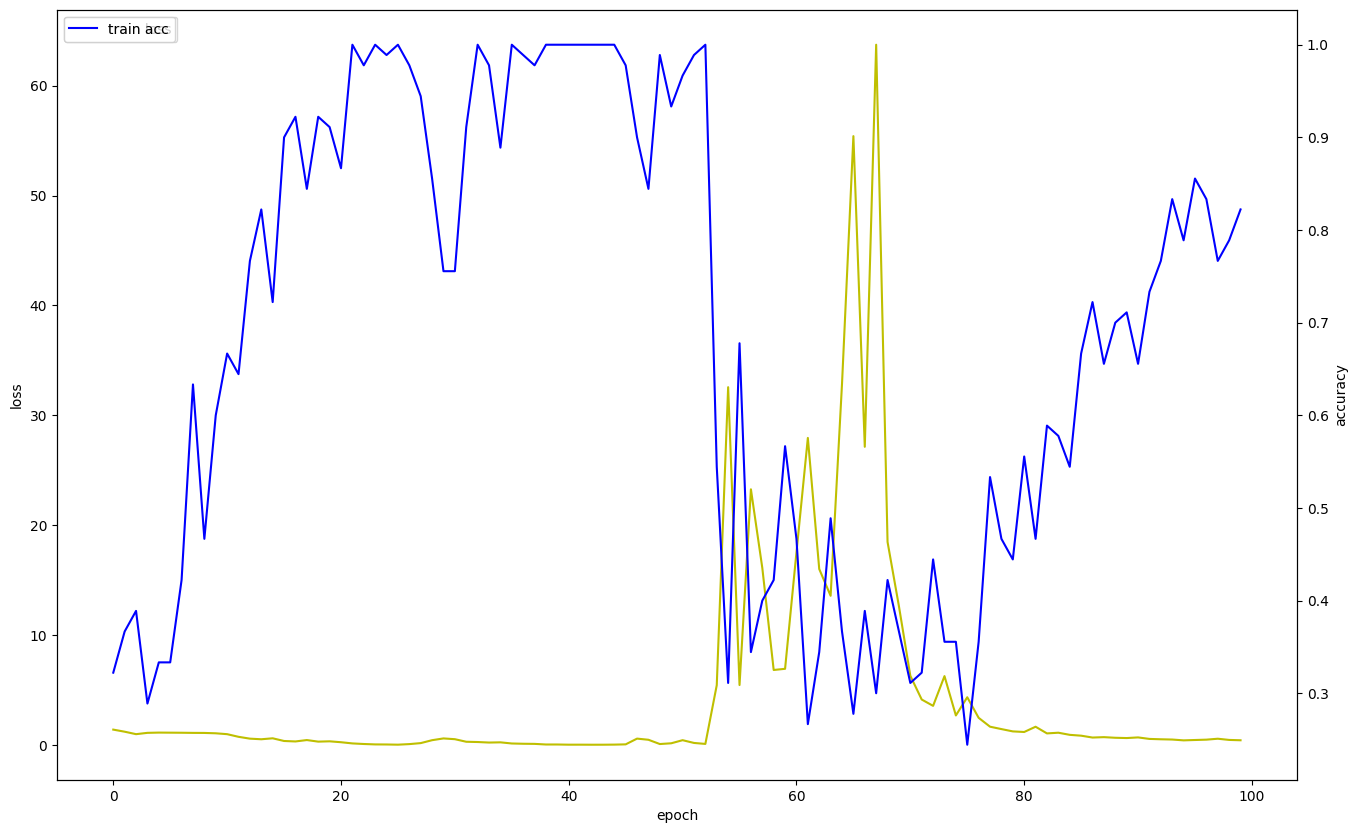

In [210]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
# loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
# acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [91]:
model.save('action.h5')

In [7]:
model_change = int(input('모델을 불러 오고 싶으면 1 을 입력하시오'))
if model_change == 1:
    model_number= (input('원하는 모델을 입력하십시오'))
    print(f'{model_number}를 입력하셨습니다.')
    model_path = glob.glob(f'./model_1_acc/{model_number}*')
    model = load_model(*model_path)

22를 입력하셨습니다.


In [106]:
model_change = int(input('모델을 불러 오고 싶으면 1 을 입력하시오'))
if model_change == 1:
    model_number= (input('원하는 모델을 입력하십시오'))
    print(f'{model_number}를 입력하셨습니다.')
    model_path = glob.glob(f'./model_1_loss/{model_number}*')
    model = load_model(*model_path)

100를 입력하셨습니다.


In [13]:

sequence = [] 
sentence= [] 
threshold = 0.5
# flag = bring_img('flag')

cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence= 0.5, min_tracking_confidence= 0.5) as holistic:
    while cap.isOpened():
        ret ,frame = cap.read()
        frame, results = mediapipe_detection(frame,holistic ) 
        # draw_landmarks(frame, results)
        key_points = extract_key_points(results)
        sequence.append(key_points)
        sequence= sequence[:30]
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]

            print(actions[np.argmax(res)])
        try:
            if res[np.argmax(res)] > threshold:
                if len(sentence) > 0 :
                    if actions[np.argmax(res)] == sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])
        except:
            pass
        
        if len(sentence) > 5:
            sentence = sentence[-5:]
        
        # frame = prob_viz(res, actions, frame, colors)
        # put_4img(frame,flag[0],flag[1],flag[2],flag[3], flag[4],flag[5],flag[6],flag[7] )
        cv2.rectangle(frame, (0,0), (640,40), (245,117,16) , -1 )
        cv2.putText(frame, actions[np.argmax(res)], (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2,cv2.LINE_AA )

        
        cv2.imshow('opencv', frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break 

cap.release()
cv2.destroyAllWindows()
        

1/1 [==============================] - 0s 84ms/step
left
1/1 [==============================] - 0s 353ms/step
left
1/1 [==============================] - 0s 184ms/step
left
1/1 [==============================] - 0s 189ms/step
left
1/1 [==============================] - 0s 180ms/step
left
1/1 [==============================] - 0s 170ms/step
left
1/1 [==============================] - 0s 189ms/step
left
1/1 [==============================] - 0s 177ms/step
left
1/1 [==============================] - 0s 191ms/step
left
1/1 [==============================] - 0s 197ms/step
left
1/1 [==============================] - 0s 181ms/step
left
1/1 [==============================] - 0s 212ms/step
left
1/1 [==============================] - 0s 170ms/step
left
1/1 [==============================] - 0s 180ms/step
left
1/1 [==============================] - 0s 182ms/step
left
1/1 [==============================] - 0s 196ms/step
left
1/1 [==============================] - 0s 173ms/step
left
1/1 [==========

In [ ]:
if len(sequence) == 30:
    res = model.predict(np.expand_dims(sequence, axis=0))[0]


In [214]:

cap.release()
cv2.destroyAllWindows()